### Naive Bayes Classification
Import all necessary packages and functions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import vstack, hstack, csr_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay

We will be looking into 3 different models:

1. Naive Bayes classification on N-grams + Bag of Words (BoW)
2. Naive Bayes classification on N-grams + TF-IDF
3. Naive Bayes classification on BoW + TF-IDF

In [2]:
with open('training_ngrams_countvec.pkl', 'rb') as f:
    ngrams_bow = pickle.load(f)

print(ngrams_bow.info())

with open('training_ngrams_tfidf.pkl', 'rb') as f:
    ngrams_tfidf = pickle.load(f)

print(ngrams_tfidf.info())


with open('engineered_features_bow_tfidf.pkl', 'rb') as f:
    bow_tfidf_dict = pickle.load(f)

bow_tfidf = pd.DataFrame(bow_tfidf_dict)

print(bow_tfidf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100784 entries, 0 to 100783
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   body                100784 non-null  object
 1   cleaned_body        100784 non-null  object
 2   label               100784 non-null  int64 
 3   tokens              100784 non-null  object
 4   body_countvec       100784 non-null  object
 5   body_char_countvec  100784 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100784 entries, 0 to 100783
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   body             100784 non-null  object
 1   cleaned_body     100784 non-null  object
 2   label            100784 non-null  int64 
 3   tokens           100784 non-null  object
 4   body_tfidf       100784 non-null  object
 5   body_c

/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using ve

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125947 entries, 0 to 125946
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   X_bow             125947 non-null  object
 1   X_tfidf           125947 non-null  object
 2   label             125947 non-null  int64 
 3   bow_vectorizer    125947 non-null  object
 4   tfidf_vectorizer  125947 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.8+ MB
None


In [3]:
X_ngb_count = vstack(ngrams_bow['body_countvec'].values)
X_ngb_char = vstack(ngrams_bow['body_char_countvec'].values)
y_ngb = ngrams_bow['label'].values
X_ngb = hstack([X_ngb_count, X_ngb_char])

print(f"N-grams + BoW Feature matrix shape: {X_ngb.shape}")
print(f"N-grams + BoW Labels shape: {y_ngb.shape}")

X_ngt_count = vstack(ngrams_tfidf['body_tfidf'].values)
X_ngt_char = vstack(ngrams_tfidf['body_char_tfidf'].values)
y_ngt = ngrams_tfidf['label'].values
X_ngt = hstack([X_ngt_count, X_ngt_char])

print(f"N-grams + TF-IDF Feature matrix shape: {X_ngt.shape}")
print(f"N-grams + TF-IDF Labels shape: {y_ngt.shape}")

N-grams + BoW Feature matrix shape: (100784, 1500)
N-grams + BoW Labels shape: (100784,)
N-grams + TF-IDF Feature matrix shape: (100784, 1500)
N-grams + TF-IDF Labels shape: (100784,)


Since the Bow + TF-IDF dataset has more entries we will do random sampling.

In [4]:
sampled = bow_tfidf.sample(n=100784, random_state=42)

# Convert the sampled data into sparse matrices
X_bow_sampled = vstack(sampled['X_bow'].values)
X_tfidf_sampled = vstack(sampled['X_tfidf'].values)

X_btf = hstack([X_bow_sampled, X_tfidf_sampled])
y_btf = sampled['label'].values

print(f"BoW + TF-IDF Feature matrix shape: {X_btf.shape}")
print(f"BoW + TF-IDF Labels shape: {y_btf.shape}")

BoW + TF-IDF Feature matrix shape: (100784, 20000)
BoW + TF-IDF Labels shape: (100784,)


### POS Tag Sequence Feature Integration
Model Training (general function)

In [5]:
def training(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    y_probs = nb_model.predict_proba(X_test)[:, 1]
    return X_train, X_test, y_train, y_test, nb_model, y_pred, y_probs

In [6]:
X_train_1, X_test_1, y_train_1, y_test_1, nb_model_1, y_pred_1, y_probs_1 = training(X_ngb, y_ngb)
X_train_2, X_test_2, y_train_2, y_test_2, nb_model_2, y_pred_2, y_probs_2 = training(X_ngt, y_ngt)
X_train_3, X_test_3, y_train_3, y_test_3, nb_model_3, y_pred_3, y_probs_3 = training(X_btf, y_btf)

In [7]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_ngb, y_ngb, test_size=0.2, random_state=42)
nb_model_1 = MultinomialNB()
nb_model_1.fit(X_train_1, y_train_1)
y_pred_1 = nb_model_1.predict(X_test_1)
y_probs_1 = nb_model_1.predict_proba(X_test_1)[:, 1]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_ngt, y_ngt, test_size=0.2, random_state=42)
nb_model_2 = MultinomialNB()
nb_model_2.fit(X_train_2, y_train_2)
y_pred_2 = nb_model_2.predict(X_test_2)
y_probs_2 = nb_model_2.predict_proba(X_test_2)[:, 1]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_btf, y_btf, test_size=0.2, random_state=42)
nb_model_3 = MultinomialNB()
nb_model_3.fit(X_train_3, y_train_3)
y_pred_3 = nb_model_3.predict(X_test_3)
y_probs_3 = nb_model_3.predict_proba(X_test_3)[:, 1]

#3 Model Training: BoW + TF-IDF

Now we shall compare the performance of all 3 models using classification report and confusion matrices.

In [8]:
def performance(y_test, y_pred, y_probs, model):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    print(model)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix : {model}", loc='center')
    plt.show()
    
    return accuracy, precision, recall, f1, auc

N-grams + BoW Performance
Accuracy:  0.8653
Precision: 0.9098
Recall:    0.7958
F1 Score:  0.8490
AUC:       0.9408


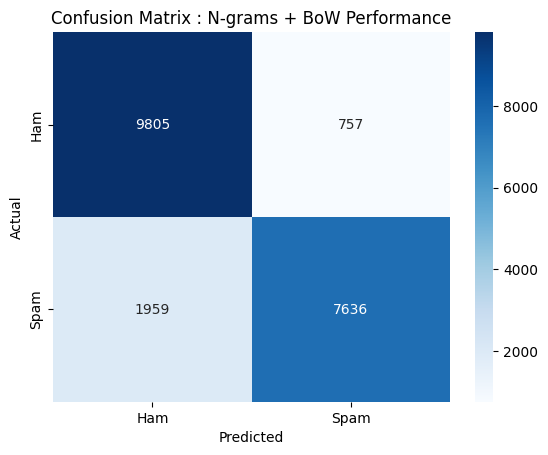

N-grams + TF-IDF Performance
Accuracy:  0.9205
Precision: 0.9179
Recall:    0.9147
F1 Score:  0.9163
AUC:       0.9772


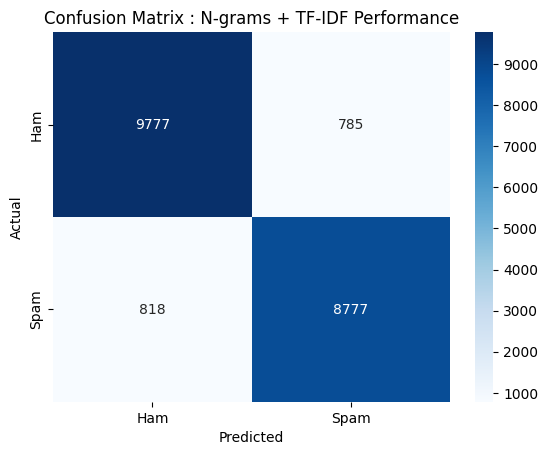

BoW + TF-IDF Performance
Accuracy:  0.9430
Precision: 0.9635
Recall:    0.9150
F1 Score:  0.9386
AUC:       0.9840


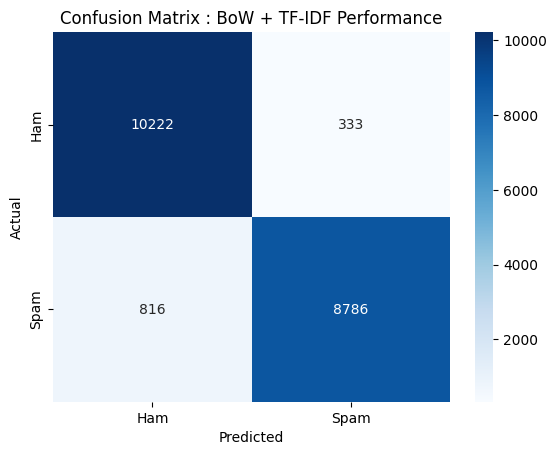

Results with Best Performing Model per Metric:
              Model      Accuracy     Precision        Recall      F1 Score  \
0     N-grams + BoW      0.865258      0.909806      0.795831       0.84901   
1  N-grams + TF-IDF      0.920474      0.917904      0.914747      0.916323   
2      BoW + TF-IDF      0.942997      0.963483      0.915018      0.938625   
3        Best Model  BoW + TF-IDF  BoW + TF-IDF  BoW + TF-IDF  BoW + TF-IDF   

            AUC  
0      0.940772  
1       0.97716  
2      0.983984  
3  BoW + TF-IDF  


In [9]:
results = []

acc1, prec1, rec1, f1_1, auc1 = performance(y_test_1, y_pred_1, y_probs_1, "N-grams + BoW Performance")
acc2, prec2, rec2, f1_2, auc2 = performance(y_test_2, y_pred_2, y_probs_2, "N-grams + TF-IDF Performance")
acc3, prec3, rec3, f1_3, auc3 = performance(y_test_3, y_pred_3, y_probs_3, "BoW + TF-IDF Performance")

results.append(['N-grams + BoW', acc1, prec1, rec1, f1_1, auc1])
results.append(['N-grams + TF-IDF', acc2, prec2, rec2, f1_2, auc2])
results.append(['BoW + TF-IDF', acc3, prec3, rec3, f1_3, auc3])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
best_model_acc = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model_prec = results_df.loc[results_df['Precision'].idxmax(), 'Model']
best_model_rec = results_df.loc[results_df['Recall'].idxmax(), 'Model']
best_model_f1 = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
best_model_auc = results_df.loc[results_df['AUC'].idxmax(), 'Model']

# Add a row for the best performing model
best_model_row = pd.DataFrame([['Best Model', best_model_acc, best_model_prec, best_model_rec, best_model_f1, best_model_auc]], columns=results_df.columns)
results_df = pd.concat([results_df, best_model_row], ignore_index=True)
print("Results with Best Performing Model per Metric:")
print(results_df)

It seems BoW + TF-IDF outperforms both N-grams models for all the metrics. The following ROC curves help to visualise the FPR which will be important especially for classification modelling.

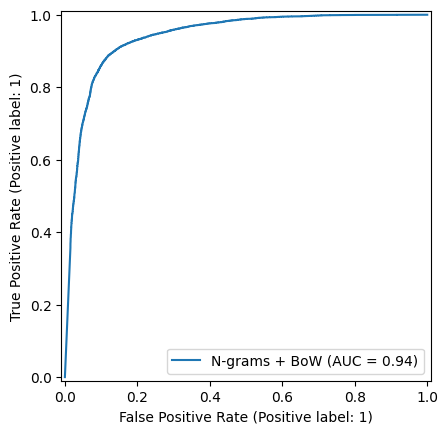

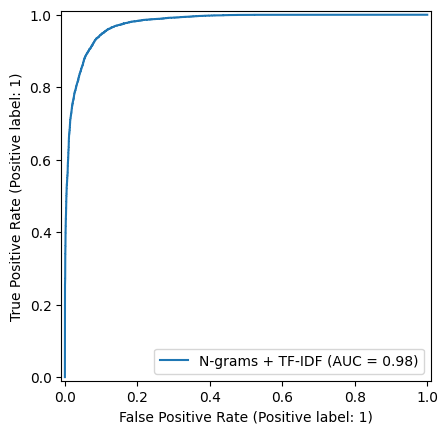

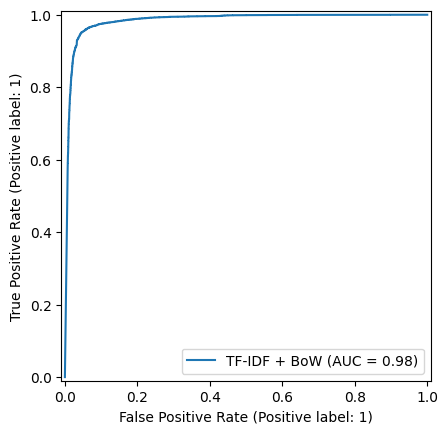

In [10]:
RocCurveDisplay.from_estimator(nb_model_1, X_test_1, y_test_1, name="N-grams + BoW")
RocCurveDisplay.from_estimator(nb_model_2, X_test_2, y_test_2, name="N-grams + TF-IDF")
RocCurveDisplay.from_estimator(nb_model_3, X_test_3, y_test_3, name="TF-IDF + BoW")
plt.show()

### POS Tag Sequence Feature Integration
Adding syntactic pattern features to the dataset and including them in model training.

In [11]:
df = pd.read_csv("full_df.csv")
df.head()

,body,cleaned_body,label,pos_tags,percentage_vb_dt_nn,percentage_vb_jj_nn,percentage_nn_md_vb,tokens
0,Subject: naturally irresistible your corporate...,naturally irresistible your corporate identity...,1,"['RB', 'JJ', 'PRP$', 'JJ', 'NN', 'NN', 'VBZ', ...",3.743316,2.139037,1.069519,"['naturally', 'irresistible', 'corporate', 'id..."
1,Subject: the stock trading gunslinger fanny i...,the stock trading gunslinger fanny is merrill ...,1,"['DT', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'C...",0.000000,0.000000,0.000000,"['stock', 'trading', 'gunslinger', 'fanny', 'm..."
2,Subject: unbelievable new homes made easy im ...,unbelievable new homes made easy im wanting to...,1,"['JJ', 'JJ', 'NNS', 'VBN', 'JJ', 'JJ', 'VBG', ...",1.351351,0.000000,0.000000,"['unbelievable', 'new', 'home', 'made', 'easy'..."
3,Subject: 4 color printing special request add...,color printing special request additional info...,1,"['NN', 'VBG', 'JJ', 'NN', 'JJ', 'NN', 'RB', 'V...",1.562500,4.687500,0.000000,"['color', 'printing', 'special', 'request', 'a..."
4,"Subject: do not have money , get software cds ...",do not have money get software cds from here s...,1,"['VBP', 'RB', 'VB', 'NN', 'NN', 'NN', 'NNS', '...",2.564103,2.564103,0.000000,"['money', 'get', 'software', 'cd', 'software',..."


In [12]:
tfidf_vectorizer = bow_tfidf["tfidf_vectorizer"].iloc[0]
bow_vectorizer = bow_tfidf["bow_vectorizer"].iloc[0]
X_tfidf = vstack(bow_tfidf["X_tfidf"].values)
X_bow = vstack(bow_tfidf["X_bow"].values)
y = bow_tfidf["label"].values
X_pos = df[["percentage_vb_dt_nn", "percentage_vb_jj_nn", "percentage_nn_md_vb"]].values
X_pos_sparse = csr_matrix(X_pos)
X_combined = hstack([X_tfidf, X_bow, X_pos_sparse])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [13]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

In [24]:
def evaluate_model(X_features, y, name="Model"):
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42
    )
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

In [25]:
X_pos_sparse = csr_matrix(X_pos)
evaluate_model(hstack([X_bow, X_tfidf, X_pos_sparse]), y, name="BoW + TF-IDF + POS")

BoW + TF-IDF + POS Performance
Accuracy:  0.9468
Precision: 0.9582
Recall:    0.9277
F1 Score:  0.9427
AUC:       0.9836


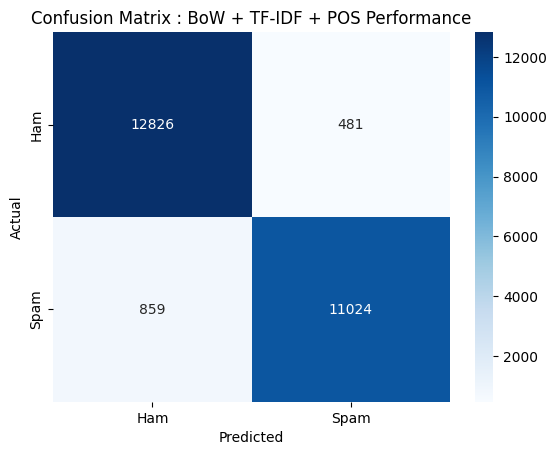

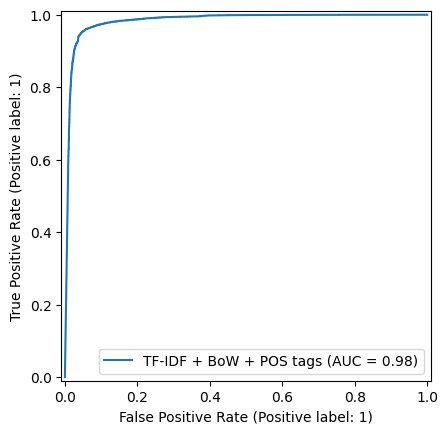

In [26]:
performance(y_test, y_pred, y_probs, "BoW + TF-IDF + POS Performance")
RocCurveDisplay.from_estimator(model, X_test, y_test, name="TF-IDF + BoW + POS tags")
plt.show()


### Model explainability

Model explainability for best performing model (TF-IDF + BoW + POS Tagging) using Log Probability for best performing features

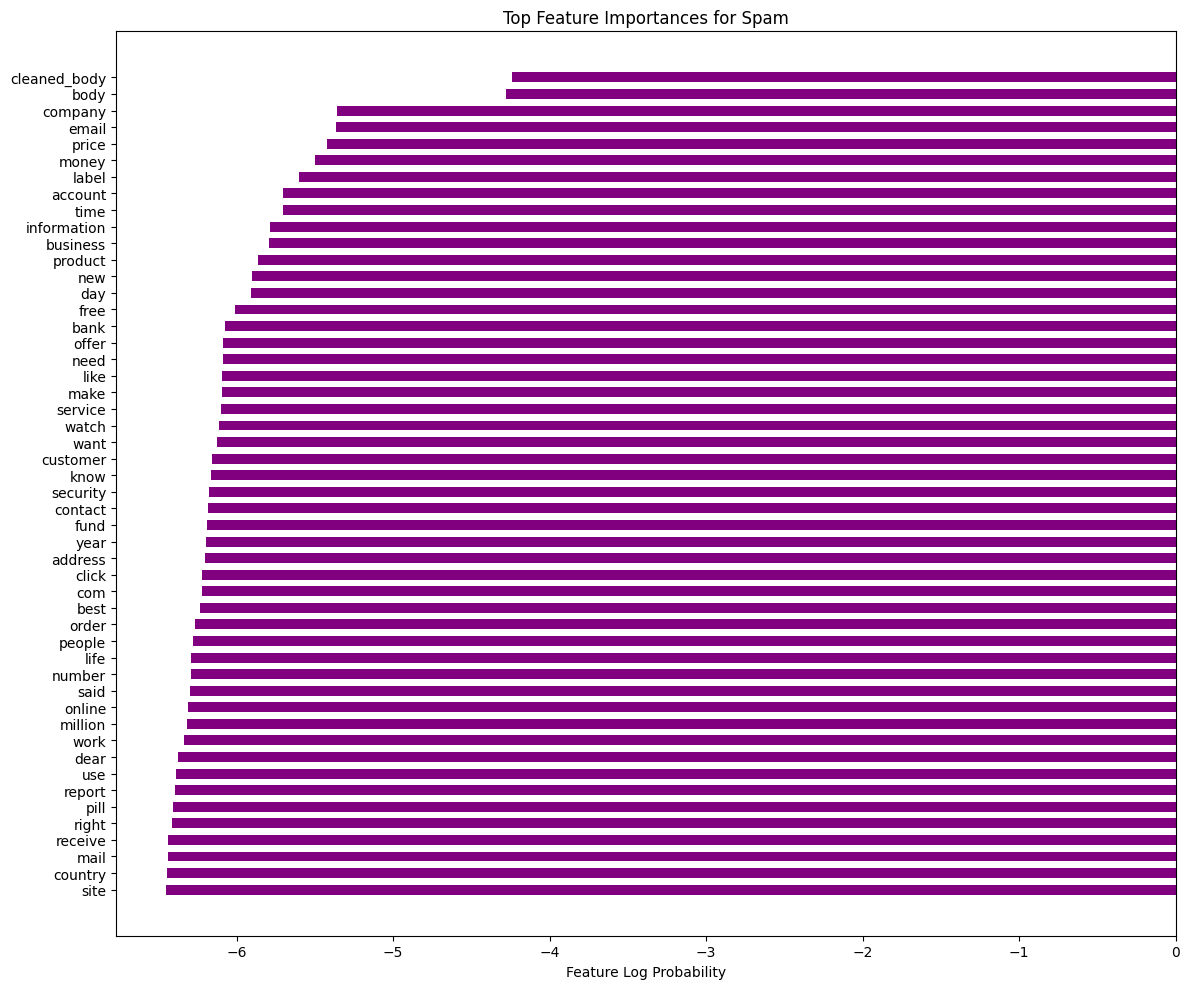

In [27]:
feature_log_prob = model.feature_log_prob_

bow_feature_names = bow_vectorizer.get_feature_names_out()
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
pos_feature_names = df.columns.tolist()
combined_feature_names = list(bow_feature_names) + list(tfidf_feature_names) + pos_feature_names

feature_importance_dict = dict(zip(combined_feature_names, feature_log_prob[1]))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_n = 50
top_features_names = [feat[0] for feat in sorted_features[:top_n]]
top_features_scores = [feat[1] for feat in sorted_features[:top_n]]

index = np.arange(top_n)
bar_width = 0.6

plt.figure(figsize=(12, 10))
plt.barh(index, top_features_scores, bar_width, color='purple')
plt.xlabel('Feature Log Probability')
plt.title('Top Feature Importances for Spam')
plt.yticks(index, top_features_names)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

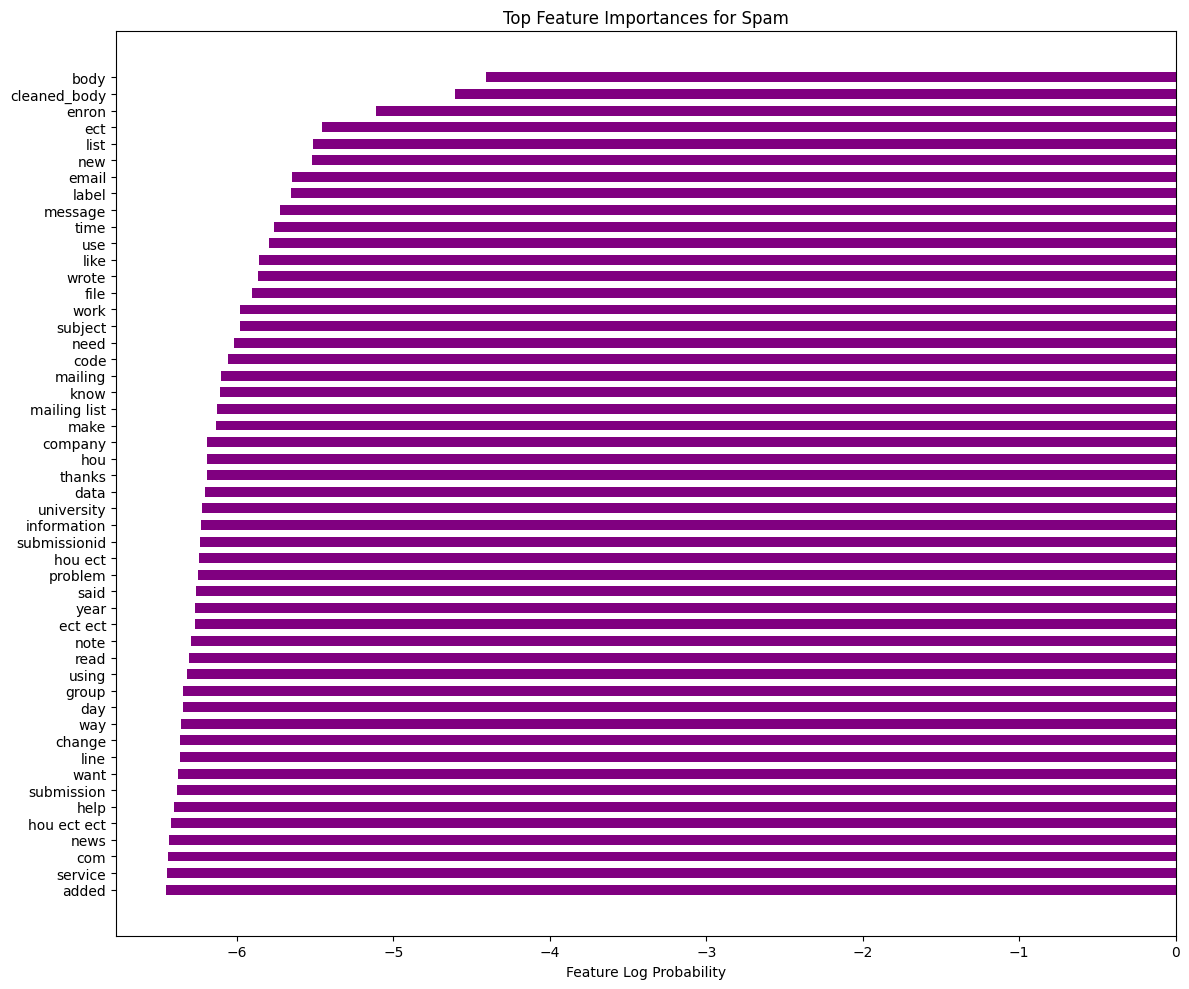

In [28]:
feature_importance_dict = dict(zip(combined_feature_names, feature_log_prob[0]))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_n = 50
top_features_names = [feat[0] for feat in sorted_features[:top_n]]
top_features_scores = [feat[1] for feat in sorted_features[:top_n]]

index = np.arange(top_n)
bar_width = 0.6

plt.figure(figsize=(12, 10))
plt.barh(index, top_features_scores, bar_width, color='purple')
plt.xlabel('Feature Log Probability')
plt.title('Top Feature Importances for Non-spam')
plt.yticks(index, top_features_names)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()